In [7]:
# Bibliothek für mehr-D Daten (speziell für NetCDF-Daten; Zeit, geografische Koordinaten, ...)
import xarray as xr
import dask

import numpy as np
from matplotlib import pyplot as plt

In [8]:
## Auswahl der Daten
# https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_NRT_008_046/services

# xr.open_dataset = Funktion, um Datensatz im NetDCF-Format öffnen
ds_sst = xr.open_dataset(
    "/home/jovyan/my_materials/data/sst_1m.nc",
    # aktiviert Lazy-Loading mit Bibliothek Dask
    # Dask teilt Datensatz in kleinere Chunks auf, die nur bei Bedarf geladen werden in Arbeitsspeicher
    chunks="auto",
)
# Umbenennen
ds_sst = ds_sst.rename_vars(sea_surface_temperature="sst")
ds_sst = ds_sst.rename({'latitude': 'lat', 'longitude': 'lon'})

# selbe Gitter wie SLP -> lat -90 bis 90, lon -180 bis 180

# Übersicht des Datensatz wird angezeigt
ds_sst

<xarray.Dataset> Size: 364MB
Dimensions:  (lat: 340, lon: 720, time: 372)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 1kB -79.88 -79.38 -78.88 -78.38 ... 88.62 89.12 89.62
  * lon      (lon) float32 3kB -179.9 -179.4 -178.9 -178.4 ... 178.6 179.1 179.6
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    sst      (time, lat, lon) float32 364MB dask.array<chunksize=(266, 243, 517), meta=np.ndarray>

In [9]:
## Filterzeitraum definieren

start_date = '1999-11-01'
end_date = '2023-12-01'

# Filter anwenden
gefilterte_sst = ds_sst.sel(time=slice(start_date, end_date))

# Gefilterte Daten speichern
output_path = "/home/jovyan/my_materials/data/gefilterte_sst.nc"
gefilterte_sst.to_netcdf(output_path)
print(f"Gefilterte SST-Daten wurden in {output_path} gespeichert.")

gefilterte_sst

Gefilterte SST-Daten wurden in /home/jovyan/my_materials/data/gefilterte_sst.nc gespeichert.


<xarray.Dataset> Size: 284MB
Dimensions:  (lat: 340, lon: 720, time: 290)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 1kB -79.88 -79.38 -78.88 -78.38 ... 88.62 89.12 89.62
  * lon      (lon) float32 3kB -179.9 -179.4 -178.9 -178.4 ... 178.6 179.1 179.6
  * time     (time) datetime64[ns] 2kB 1999-11-01 1999-12-01 ... 2023-12-01
Data variables:
    sst      (time, lat, lon) float32 284MB dask.array<chunksize=(184, 243, 517), meta=np.ndarray>

In [10]:
## Regionen festlegen

# 3.4 Region definieren -5...5N -170...-120E
sst_region = ds_sst.sel(lat=slice(-5,5),lon=slice(-170,-120))
# ??? -5...5 ist Grenze ist nicht direkt dabei -> liegt das an Datensammlung, dass das über .375 ... .875?

print(sst_region)

<xarray.Dataset> Size: 3MB
Dimensions:  (lat: 20, lon: 100, time: 372)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 80B -4.875 -4.375 -3.875 -3.375 ... 3.625 4.125 4.625
  * lon      (lon) float32 400B -169.9 -169.4 -168.9 ... -121.4 -120.9 -120.4
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    sst      (time, lat, lon) float32 3MB dask.array<chunksize=(266, 20, 100), meta=np.ndarray>


In [11]:
## Mittel berechnen / Jahr und Referenzwert

# berechnet SST-Durchschnitt über 3.4 Region für jedes Jahr (über Dimension Zeit und Raum -> 3.4)
sst_yearly_mean = sst_region.groupby('time.year').mean(dim=['time', 'lat', 'lon'])
print(sst_yearly_mean)

# SST-Werte und Jahre extrahieren 
years = sst_yearly_mean.coords['year'].values  # Jahreswerte als Array
sst = sst_yearly_mean['sst'].values  # Temperaturen als Array

# berechnet Referenzwert für SST = Mittelwert über gesamte Zeit
reference_mean = sst_yearly_mean['sst'].mean().compute().item()
print(reference_mean)

# berechnet Differenz jedes Jahres zum Referenzwert
yearly_differences = sst - reference_mean
print(yearly_differences)

<xarray.Dataset> Size: 376B
Dimensions:  (year: 31)
Coordinates:
    depth    float32 4B ...
  * year     (year) int64 248B 1993 1994 1995 1996 1997 ... 2020 2021 2022 2023
Data variables:
    sst      (year) float32 124B dask.array<chunksize=(1,), meta=np.ndarray>
26.978445053100586
[ 0.35401917  0.39673805 -0.19282532 -0.4698429   1.1211414  -0.17577553
 -1.1330261  -0.8549404  -0.25724983  0.68668556  0.28298187  0.39007568
  0.1038723   0.14973259 -0.47650146 -0.6802311   0.39786148 -0.34758568
 -0.7365265   0.0100708  -0.17923927  0.20752907  1.5037899   0.3854866
 -0.13662529 -0.02566338  0.4621296  -0.3203411  -0.52674675 -0.8394966
  0.90055466]


In [19]:
## Normierung

# Berechnung der Standardabweichung
std_sst = sst_yearly_mean['sst'].std().compute().item()
# Normierung der Differenzen
normalized_differences = yearly_differences / std_sst
print(normalized_differences)

[ 0.6005725   0.67304254 -0.3271167  -0.7970606   1.9019499  -0.29819274
 -1.9221115  -1.4503556  -0.43640906  1.1649213   0.48006195  0.66174024
  0.17621319  0.25401244 -0.80835646 -1.1539717   0.6749484  -0.58965844
 -1.2494735   0.01708452 -0.30406877  0.35206074  2.5510902   0.65395516
 -0.2317767  -0.04353639  0.7839754  -0.5434397  -0.89359456 -1.4241562
  1.5277375 ]


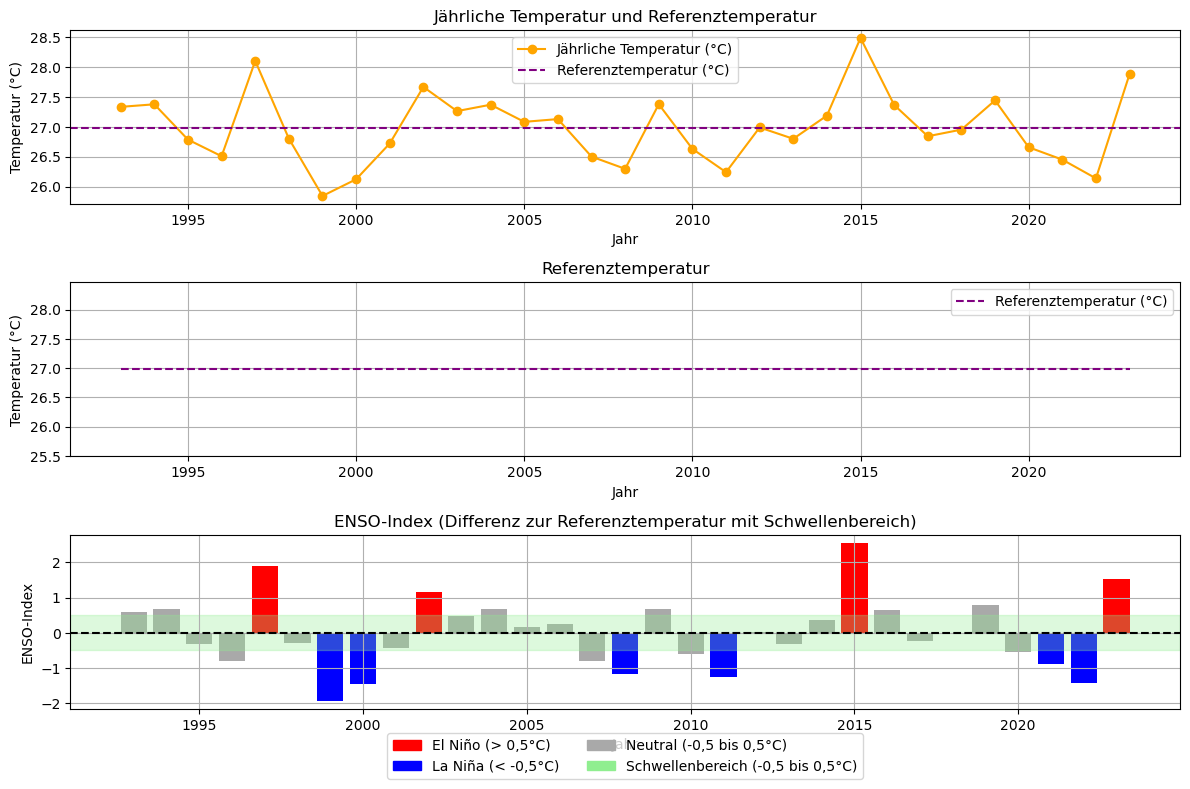

El Niño Jahre (Index): 1993 (1.90), 1994 (1.16), 1997 (2.55), 2002 (1.53)
La Niña Jahre (Index): 1996 (-0.80), 1999 (-1.92), 2000 (-1.45), 2007 (-0.81), 2008 (-1.15), 2010 (-0.59), 2011 (-1.25), 2020 (-0.54), 2021 (-0.89), 2022 (-1.42)


<Figure size 640x480 with 0 Axes>

In [21]:
## Plotten ENSO-Index über Jahre

# vgl SST Oceanic Nino Index (ONI) von Quartalen -> https://www.ncei.noaa.gov/access/monitoring/enso/sst

# Plotten der 3 Grafen
plt.figure(figsize=(12, 8))

# Plot 1: Jährliche Temperatur
# 3 Subplots -> 3 Zeilen, 1 Spalte, und 1. Plot ist in 1
plt.subplot(3, 1, 1)
# x=years, y=sst, marker=o jeder Datenpunkt mit o markieren, label ist Beschriftung
plt.plot(years, sst, color='orange', marker='o', label='Jährliche Temperatur (°C)')
# zeichnet Referenztemperatur ein (horizontale Linie)
plt.axhline(reference_mean, color='purple', linestyle='--', label='Referenztemperatur (°C)')
plt.title('Jährliche Temperatur und Referenztemperatur')
plt.xlabel('Jahr')
plt.ylabel('Temperatur (°C)')
# aktiviert Legende
plt.legend()
# fügt Gitter hinzu
plt.grid()

# Plot 2: Referenztemperatur
plt.subplot(3, 1, 2)
plt.plot(years, [reference_mean] * len(years), color='purple', linestyle='--', label='Referenztemperatur (°C)')
plt.title('Referenztemperatur')
plt.xlabel('Jahr')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.grid()

# Plot 3: Jährliche Differenz zur Referenztemperatur
plt.subplot(3, 1, 3)
# Farben basierend auf den Werten setzen
colors = ['red' if value > 0.5 else 'blue' if value < -0.5 else 'darkgrey' for value in yearly_differences]
# bar = Balkendiagramm
plt.bar(years, normalized_differences, color=colors, label='ENSO-Index')
plt.axhline(0, color='black', linestyle='--')
# Schwellenbalken hinzufügen
plt.axhspan(-0.5, 0.5, color='lightgreen', alpha=0.3, label='Schwellenbereich (-0,5 bis 0,5 °C)')
plt.title('ENSO-Index (Differenz zur Referenztemperatur mit Schwellenbereich)')
plt.xlabel('Jahr')
plt.ylabel('ENSO-Index')
#plt.legend()
# Manuelle Legende erstellen
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='El Niño (> 0,5°C)')
blue_patch = mpatches.Patch(color='blue', label='La Niña (< -0,5°C)')
grey_patch = mpatches.Patch(color='darkgrey', label='Neutral (-0,5 bis 0,5°C)')
green_patch = mpatches.Patch(color='lightgreen', label='Schwellenbereich (-0,5 bis 0,5°C)')
# Legende in die Mitte setzen
plt.legend(handles=[red_patch, blue_patch, grey_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.grid()

# Layout und Anzeige
# automatische Anpassung Abstände zwischen Plots
plt.tight_layout()
# anzeigen
plt.show()


# Jahre mit El Niño (Werte > 0,5°C) und La Niña (Werte < -0,5°C) identifizieren
el_nino_years = years[normalized_differences > 0.5]
el_nino_indices = normalized_differences[yearly_differences > 0.5]

la_nina_years = years[normalized_differences < -0.5]
la_nina_indices = normalized_differences[normalized_differences < -0.5]

# El Niño und La Niña Jahre mit Indizes zusammenfassen
el_nino_text = ", ".join([f"{year} ({index:.2f})" for year, index in zip(el_nino_years, el_nino_indices)])
la_nina_text = ", ".join([f"{year} ({index:.2f})" for year, index in zip(la_nina_years, la_nina_indices)])

# Text unter die Grafik setzen
plt.figtext(0.5, -0.1, f"El Niño Jahre (> 0,5°C): {el_nino_text}\n"
                       f"La Niña Jahre (< -0,5°C): {la_nina_text}",
            ha="center", fontsize=10, wrap=True)

# Ausgeben für Kontrolle in der Konsole
print("El Niño Jahre (Index):", el_nino_text)
print("La Niña Jahre (Index):", la_nina_text)